# Random Forest Model Analysis Walkthrough (Dynamic Rollover)

Random Forest is an ensemble learning method primarily used for classification and regression tasks. It operates by constructing a multitude of decision trees at training time and outputs the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. Random forests correct for decision trees' habit of overfitting to their training set.

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from pathlib import Path

In [2]:
# this is the path to your pickle file (should be the same location as CSVs)
path = Path('../data')

with open(path / 'dynamic_rollover_pandas_2.0.2.pkl', 'rb') as file:
    df = pickle.load(file)
df = df.reset_index(drop=True)

## Dataset Splitting
We begin by splitting our dataset into a training and testing set. This process ensures that we have a distinct set of data to evaluate the model's performance.

In [3]:
# define independent variables and dependent variable
maneuver = 'Dynamic Rollover'
X = df.drop(maneuver, axis=1)
y = df[maneuver]

In [4]:
# splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
# y_test: 
# Dynamic Rollover
# 0    51270
# 1      511
# Name: count, dtype: int64


#### Class Distribution in Test Data

The test data contains:

51,270 instances of class 0 (No Dynamic Rollover)
511 instances of class 1 (Dynamic Rollover)
This indicates an imbalanced dataset, which may influence the model's ability to correctly predict the minority class.

## Build and Fit the Model
We will set up a parameter grid with the best parameters. These parameters were developed in the modeling directory in the decision tree (dynamic rollover) file. For more information on the training and tuning of this model please refer to the modeling file.

In [5]:

# the commented out parameter values are the other tried during the testing 
params = {
    'rf__n_estimators': [200],  # 100, 200
    'rf__max_depth': [None],  # 5, 10
    'rf__min_samples_split': [2],  # 5, 10
    'rf__min_samples_leaf': [1],  # 2, 4
    'rf__max_features': ['log2'],  # 'sqrt'
    'rf__bootstrap': [False],  # False
    'rf__class_weight': ['balanced'],
    'rf__random_state': [42],
    'rf__n_jobs': [-1]
}

# create a pipeline
pipe = Pipeline([
    ('rf', RandomForestClassifier())
])

# grid search with cross-validation
f1_scorer = make_scorer(f1_score)
strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=pipe, param_grid=params, cv=strat_k_fold, scoring=f1_scorer)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_


## Make Predictions for Model Evaluation

In [6]:
y_pred = best_model.predict(X_test)
print(classification_report(y_test.values, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9999    1.0000    1.0000     51270
           1     0.9980    0.9941    0.9961       511

    accuracy                         0.9999     51781
   macro avg     0.9990    0.9971    0.9980     51781
weighted avg     0.9999    0.9999    0.9999     51781



In [11]:
print(confusion_matrix(y_test, y_pred))

[[51269     1]
 [    3   508]]


In [7]:
recall_scorer = make_scorer(recall_score, average='weighted')
# Create learning curve data using learning_curve function with recall scoring
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y, cv=5, scoring=recall_scorer, train_sizes=np.linspace(0.1, 1.0, 10)
)

In [8]:
# Calculate mean and standard deviation for training and cross-validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

## Visualizations
These visualizations will provide a comprehensive understanding of the model's performance, the features that drive decisions, and how the model's performance evolves as more data is added.

### Learning Curve Analysis

A learning curve shows the validation and training score of an estimator for varying numbers of training samples. It's a tool to diagnose bias and variance.

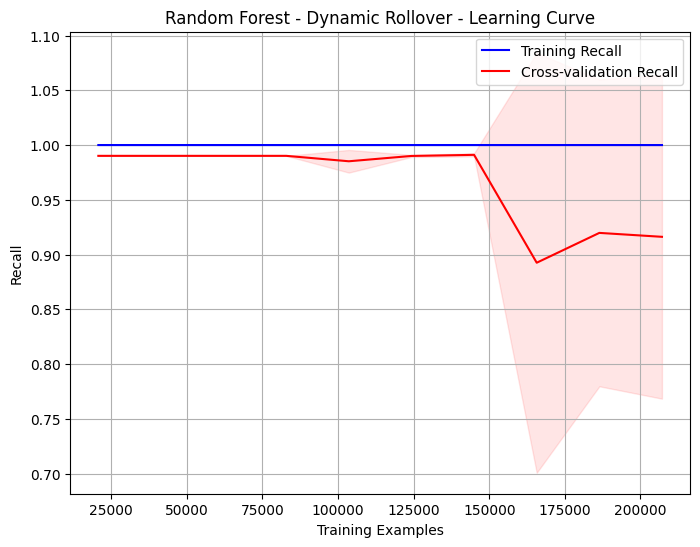

In [9]:
# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Recall', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='blue')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation Recall', color='red')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='red')

plt.title(f'Random Forest - {maneuver} - Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Recall')
plt.legend(loc='best')
plt.grid()
plt.show()

### Feature Importance

Understanding which features have the most impact on predictions can provide insights into the data and the model's behavior. Here, we rank the features based on their importance.

Most important variables:
Altitude(MSL): 0.13677521857315977
Roll: 0.04288178644714054
Yaw Acceleration: 0.08763573591649475
Altitude(AGL): 0.1259256041542172
Roll Rate: 0.03772277413378339
Roll Acceleration: 0.12384875223219956
Collective Pos-[0]: 0.010291695427094783
Pitch Acceleration: 0.12149699561681251
Rotor Torque-[0]: 0.0
Pitch Rate: 0.0365694458366391
Cyclic Pitch Pos-[0]: 0.024023224600683412
Gross Weight: 0.025183260848163202
Wind Speed(True): 0.029632153359450672
Groundspeed: 0.03186505781217571
Pitch: 0.04128339416698641
Yaw: 0.039931343314246144
Sideslip Angle: 0.02629547841914004
Yaw Rate: 0.03577941368027163
Pedal Pos: 0.0
Cyclic Roll Pos-[0]: 0.022858665461341066


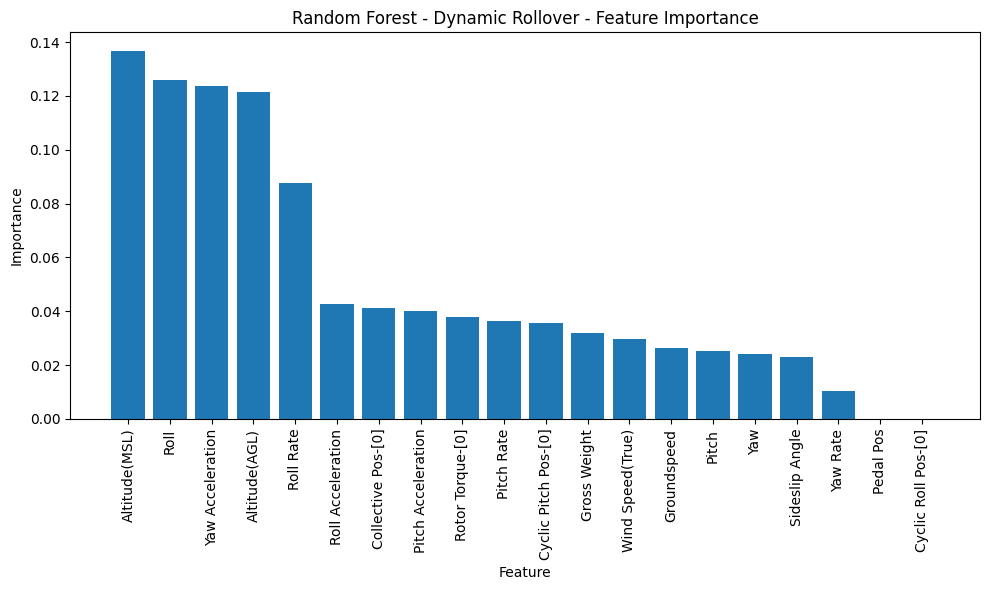

In [10]:
rf_model = best_model.named_steps['rf']
feature_importances = rf_model.feature_importances_

# Train the model on the entire dataset
best_model.fit(X, y)

# Sort the feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = X.columns[sorted_indices]

# Retrieve feature names
feature_names = list(X_train.columns)

# Print the most important variables
print("Most important variables:")
for i in sorted_indices:
    print(f"{feature_names[i]}: {sorted_feature_importances[i]}")
# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), sorted_feature_importances, align='center')
plt.xticks(range(X.shape[1]), sorted_feature_names, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title(f'Random Forest - {maneuver} - Feature Importance')
plt.tight_layout()
plt.show()

## Model Evaluation Summary:

### Learning Curve Analysis:
The random forest model learning curve shows the recall score for the cross validation training went down with a higher number of training examples. This suggests that the random forest model may have overfit on the training data.

### Feature Importance Analysis:
- Altitude(MSL), Roll, and Yaw Acceleration were the top features.
- These features did not account for a verify high proportion of importance.
- Future research could look into how these variables interact and how their changes could correlate with one another.